In [1]:
%matplotlib inline

In [ ]:
#%%writefile segmentation_3D_thirdversion.py

from segmentation_functions import resample,grow
from .finding_biggest_lung import arrange_slices, normalization, get_pixels_hu,creating_mask
from seed_evaluation import evaluate_seed
import scipy.ndimage.interpolation as inter
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io as spio
import pydicom
import time

slices_path = "G:/CTimages/"
indices_path ="G:/Results/Lungs Masks indexes/ok/Separated Lungs"
separation_path = "G:/Results/Separator/"
segmentations_results_path = "G:/Plans/CT/Lungs/segmentation_results/third/"
seeds_path = "G:/CTimages/CT/Images/Seeds/"
indices_folder= os.listdir(indices_path)

results = []

for num,each_mask in enumerate(indices_folder):

    print(num)
    #Loading data--------------------------------------------------------------------------------------------------------
    opened = spio.loadmat(indices_path+'/'+each_mask, squeeze_me=True)["indexes"]
    patient_id = each_mask.split(" ", each_mask.count(each_mask))[0] 
    separador = spio.loadmat(separation_path+'/'+patient_id+'_separator', squeeze_me=True)["separator"]
    pre_region = each_mask.split("_", each_mask.count(each_mask))[1]
    region = pre_region.split("_", pre_region.count(pre_region))[0]
    print("Patient-id: "+ str(patient_id))
    print(region)
    
    #Reading the data--------------------------------------------------------------------------------------------------------
    slices= arrange_slices(slices_path,patient_id)
    normalized_volume=normalization(slices)
    normalized_array = np.array(normalized_volume)
    
    #Separating left and right side------------------------------------------------------------------------------------------
    #possible improvement: define non-used side as the minimum of intensity of the volume
    volume = np.zeros(normalized_array.shape)
    cols = normalized_array.shape[2]
    
    if region =='left':
        volume[:,:,separador:cols] = normalized_array[:,:,separador:cols]
    elif region =='right':
        volume[:,:,0:separador] = normalized_array[:,:,0:separador]
    volume_resampled, spacing = resample(volume, slices, [5,5,5])
    

    #Seed--------------------------------------------------------------------------------------------------------------------
    max_seeding = 39705+50
    min_seeding = 3257
    seed_1 = spio.loadmat(seeds_path+'/'+patient_id+'_seed1', squeeze_me=True)["seed1"]
    seed_2 = spio.loadmat(seeds_path+'/'+patient_id+'_seed2', squeeze_me=True)["seed2"]
     
    if region=='left':
        seeds = [seed_2]
    elif region =='right':
        seeds = [seed_1]
    
    mask = creating_mask(seeds,normalized_array)
    mask_resampled, spacing = resample(mask, slices, [5,5,5])
    j = np.unravel_index(np.argmax(mask_resampled), mask_resampled.shape) #tupla
    print('j: '+str(j))
    seeds= [j] #lista

    interval = volume_resampled.copy()
    interval[j]=5000
    plt.imshow(interval[:,j[1],:])
    plt.show()
    
    evaluation = evaluate_seed(seeds[0], opened, slices, normalized_array, region, patient_id)
    results.append(evaluation)
    
    
    #Segmentation------------------------------------------------------------------------------------------------------------
    thresh = 225# tentar 300
    vizinhanca = 1
    first_seg = np.zeros(volume_resampled.shape, dtype=np.bool)
    size_seeds = len(seeds)
    counter = max_seeding+50
    while counter > max_seeding or counter< min_seeding:
        if size_seeds>1:
            for i in range(len(seeds)-1):
                start = time.time()
                seg, counter = grow(volume_resampled,seeds[i],thresh,1,first_seg) 
                print('finish:'+str(i))
                if counter>max_seeding:
                    thresh = thresh-10
                if counter<min_seeding:
                    thresh = thresh+10
                else:
                    first_seg = seg
        else:
            print('starting segmentation...')
            pre_seed = tuple(seeds[0])
            start = time.time()
            seg, counter = grow(volume_resampled,pre_seed,thresh,vizinhanca,first_seg)
            stop = time.time()
            print(thresh)
            if counter>max_seeding:
                thresh = thresh-10
            if counter<min_seeding:
                thresh = thresh+10
        plt.imshow(seg[:,j[1],:])
    plt.show()
    
    del normalized_array
    del volume_resampled
    del volume
    del slices
    print("Elapsed time: %.3f seconds." % (stop - start))
    
    name = segmentations_results_path+"3DVolumeSegmented_"+str(patient_id)+'_'+str(region)+"_"+str(thresh)
    np.save(name, seg)
    

# Specific patient

right
[array([ 90, 255, 197], dtype=uint8)]
j: (45, 49, 38)


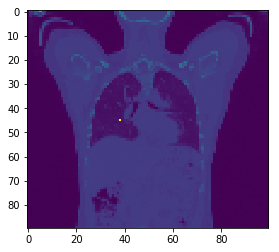

starting segmentation...
225


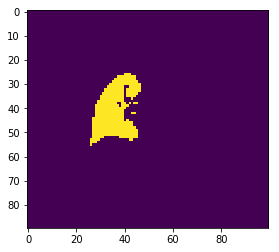

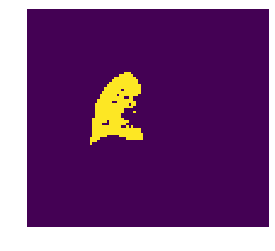

In [13]:

from segmentation_functions import resample,grow
from .finding_biggest_lung import arrange_slices, normalization, get_pixels_hu,creating_mask
from seed_evaluation import evaluate_seed
import scipy.ndimage.interpolation as inter
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.io as spio
import pydicom
import time


slices_path = "G:/CTimages/"
separation_path = "G:/Results/Separator/"
segmentations_results_path = "G:/Plans/CT/Lungs/segmentation_results/Iterative/third/"
masks_path = "G:/Masks/separated/"
seeds_path = "G:/Results/Seeds/third/"

# Results of seeding method 
results = []

patient_id ='49950151' #each_mask.split(" ", each_mask.count(each_mask))[0] 
slices= arrange_slices(slices_path,patient_id)
normalized_volume=normalization(slices)
normalized_array = np.array(normalized_volume)
volume_resampled, spacing = resample(normalized_array, slices, [5,5,5])

seed_1 = spio.loadmat(seeds_path+'/'+patient_id+'_seed1', squeeze_me=True)["seed1"]
seed_2 = spio.loadmat(seeds_path+'/'+patient_id+'_seed2', squeeze_me=True)["seed2"]
#pre_region = each_mask.split("_", each_mask.count(each_mask))[1]
#region = pre_region.split("_", pre_region.count(pre_region))[0] 
region = 'right'
print(region)

if region=='left':
    seeds = [seed_2]
elif region =='right':
    seeds = [seed_1]

print(seeds)
mask = creating_mask(seeds,normalized_array)
mask_resampled, spacing = resample(mask, slices, [5,5,5])  
j = np.unravel_index(np.argmax(mask_resampled), mask_resampled.shape) #tupla
print('j: '+str(j))
seeds= [j] #lista

interval = volume_resampled.copy()
interval[j]=5000
plt.imshow(interval[:,j[1],:])
plt.show()

pre_seed = tuple(seeds)
max_seeding = 39705+50
min_seeding = 3257
counter=0
thresh = 225
size_seeds = len(seeds)
#evaluation = evaluate_seed(seeds[0], opened, slices, normalized_array, region, patient_id)
first_seg = np.zeros(volume_resampled.shape, dtype=np.bool)

while counter > max_seeding or counter< min_seeding:
    if size_seeds>1:
        for i in range(len(seeds)-1):
            start = time.time()
            seg, counter = grow(volume_resampled,seeds[i],thresh,1,first_seg) 
            print('finish:'+str(i))
            if counter>max_seeding:
                thresh = thresh-10
            if counter<min_seeding:
                thresh = thresh+10
            else:
                first_seg = seg
    else:
        print('starting segmentation...')
        pre_seed = tuple(seeds[0])
        start = time.time()
        seg, counter = grow(volume_resampled,pre_seed,thresh,1,first_seg)
        stop = time.time()
        print(thresh)
        if counter>max_seeding:
            thresh = thresh-10
        if counter<min_seeding:
            thresh = thresh+10
        plt.imshow(seg[:,j[1],:])
    plt.show()
    plt.axis('off')

plt.imshow(seg[:,50,:])
name = segmentations_results_path+"3DVolumeSegmented_"+str(patient_id)+'_'+str(region)+"_"+str(thresh)
np.save(name, seg)